<a href="https://colab.research.google.com/github/madelinemccombe/LaunchDS/blob/master/Model_Selection_Medium.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
from google.colab import files
upload = files.upload()

Saving mushrooms.csv to mushrooms.csv


In [0]:
import pandas as pd
import numpy as np
import seaborn as sns

In [5]:
mushroom = pd.read_csv('mushrooms.csv')
mushroom.head()

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,stalk-shape,stalk-root,stalk-surface-above-ring,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,p,x,s,n,t,p,f,c,n,k,e,e,s,s,w,w,p,w,o,p,k,s,u
1,e,x,s,y,t,a,f,c,b,k,e,c,s,s,w,w,p,w,o,p,n,n,g
2,e,b,s,w,t,l,f,c,b,n,e,c,s,s,w,w,p,w,o,p,n,n,m
3,p,x,y,w,t,p,f,c,n,n,e,e,s,s,w,w,p,w,o,p,k,s,u
4,e,x,s,g,f,n,f,w,b,k,t,e,s,s,w,w,p,w,o,e,n,a,g


In [43]:
target = mushroom['class']
def fix(x):
  if x=='p':
    return 1
  else: 
    return 0
target = target.apply(fix)

features = mushroom.iloc[:, 1:]
features = pd.get_dummies(features, prefix = features.columns, drop_first=True)
print('The number of entries is:', len(features))
print('The proportion of poisonous entries is:', sum(target)/len(target))

The number of entries is: 8124
The proportion of poisonous entries is: 0.48202855736090594


The number of expanded features is: 95
The number of features with variance less than 0.05: 56


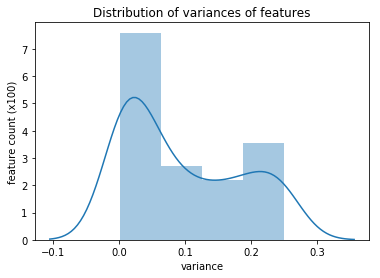

In [21]:
# variance thesholding
col_sum = features.apply(np.var, axis=0)
col_sort = col_sum.sort_values()
print('The number of expanded features is:', len(col_sum))
print('The number of features with variance less than 0.05:', len(col_sort[col_sort<0.1])) 
  # number of columns that define less than 3% of the data

# plot of variances, cut off at 0.1
col_sort
g = sns.distplot(col_sort)
g.set_title('Distribution of variances of features')
g.set_ylabel('feature count (x100)')
g.set_xlabel('variance');

In [22]:
columns = col_sort[col_sort>=0.1]
print('The final number of features to be used is:', len(columns))
features_final = features[columns.index]

The final number of features to be used is: 39


In [0]:
# run to silence unecessary warnings
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

In [0]:
# extensive gridsearch
def perform_gridsearch(features,target):
  '''Performs gridsearch on Logistic Regression'''
  import numpy as np
  from sklearn.linear_model import LogisticRegression
  from sklearn.model_selection import GridSearchCV

  # # # Create model (can change to a different model/parameters)
  model = LogisticRegression()
  # Create range of candidate penalty hyperparameter values
  penalty = ['l1', 'l2']
  # Create range of candidate regularization hyperparameter values C
  C = np.logspace(0, 4, 10)
  # Create dictionary hyperparameter candidates
  hyperparameters = dict(C=C, penalty=penalty) 

  # Create grid search, and pass in all defined values
  gridsearch = GridSearchCV(model, hyperparameters, cv=5, verbose=1) # Fit grid search
  best_model = gridsearch.fit(features, target)
  return best_model
  print('Best Penalty:', best_model.best_estimator_.get_params()['penalty']) 
  print('Best C:', best_model.best_estimator_.get_params()['C'])
  print("The mean accuracy of the model is:",best_model.score(features, target)) 
  

In [11]:
grid = perform_gridsearch(features_final, target)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   13.6s finished


In [59]:
print(grid.best_estimator_.get_params())
print(grid.score(features_final, target))

{'C': 1.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'warn', 'n_jobs': None, 'penalty': 'l1', 'random_state': None, 'solver': 'warn', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
0.9988921713441654


In [0]:
# randomized search
def perform_randomized_search(features, target):
  '''Performs a randomized search on Logistic regression'''
  import numpy as np
  from sklearn.linear_model import LogisticRegression 
  from sklearn.model_selection import RandomizedSearchCV
  from scipy.stats import uniform

  # Create logistic regression
  model = LogisticRegression()
  # Create range of candidate regularization penalty hyperparameter values
  penalty = ['l1', 'l2']
  # Create distribution of candidate regularization hyperparameter values
  C = uniform(loc=0, scale=4)
  # Create hyperparameter options
  hyperparameters = dict(C=C, penalty=penalty)
  
  
  # Create randomized search
  randomizedsearch = RandomizedSearchCV(
    model, hyperparameters, random_state=1, n_iter=100, cv=5, verbose=1)
  # Fit randomized search
  best_model = randomizedsearch.fit(features, target)
  return best_model
  print(best_model.best_estimator_)
  print("The mean accuracy of the model is:",best_model.score(features, target))  

In [13]:
random = perform_randomized_search(features_final, target)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:   54.5s finished


In [60]:
print(random.best_estimator_.get_params())
print(random.score(features_final, target))

{'C': 0.9183088549193021, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'warn', 'n_jobs': None, 'penalty': 'l1', 'random_state': None, 'solver': 'warn', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
0.9988921713441654


In [0]:
# pipelines with grid search
def execute_pipeline(features,target):
  '''
  Takes in features(X) and target(y) and performs a grid search classification
  by Logisitic Regression, SVM, and Random Forest. Prints the best model.
  '''
  import numpy as np
  from scipy.stats import uniform
  from sklearn.linear_model import LogisticRegression 
  from sklearn.model_selection import GridSearchCV 
  from sklearn.pipeline import Pipeline, FeatureUnion 
  from sklearn.decomposition import PCA
  from sklearn.preprocessing import StandardScaler
  from sklearn.svm import SVC
  from sklearn.ensemble import RandomForestClassifier 
  
  # C = uniform(loc=0, scale=4) # optional space of candidate values
  
  # preprocessing and creating the pipe
  pca_components = PCA() ## if n_components not specified, keeps all components
  std_scaler = StandardScaler()
  preprocess = FeatureUnion([("std",std_scaler), ("pca", pca_components)])
  model = LogisticRegression()
  pipe = Pipeline([("preprocess", preprocess),
                 ("classifier", model)])
  
  # can add in other models here, just add to search_space below
  log_reg = {"classifier": [LogisticRegression()], 
                 "classifier__penalty": ['l2','l1'],
                 "classifier__C": np.logspace(0, 4, 10)}
  svm = {"classifier": [SVC()],
                 "classifier__C": [0.01,0.1,1,10,100],
                 "classifier__kernel":['linear','poly','rbf','sigmoid']}
  log_reg_solver = {"classifier": [LogisticRegression()],
                 "classifier__penalty": ['l2'],
                 "classifier__C": np.logspace(0, 4, 10),
                 "classifier__solver":['newton-cg','saga','sag','liblinear']} ##These solvers don't allow L1 penalty
  rand_forest = {"classifier": [RandomForestClassifier()],
                 "classifier__n_estimators": [10, 100, 1000],
                 "classifier__max_depth":[5,8,15,25,30,None],
                 "classifier__min_samples_leaf":[1,2,5,10,15,100],
                 "classifier__max_leaf_nodes": [2, 5,10]}
  search_space = [svm,log_reg, log_reg_solver, rand_forest]
  
  # executing pipepline
  clf = GridSearchCV(pipe, search_space, cv=5, verbose=1, n_jobs=-1) # Fit grid search
  best_model = clf.fit(features, target)
  return best_model
  print(best_model.best_estimator_)
  print("The mean accuracy of the model is:",best_model.score(features, target))

In [16]:
big = execute_pipeline(features_final, target)

Fitting 5 folds for each of 404 candidates, totalling 2020 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:  4.9min
[Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed: 16.8min
[Parallel(n_jobs=-1)]: Done 1246 tasks      | elapsed: 33.5min
[Parallel(n_jobs=-1)]: Done 1796 tasks      | elapsed: 53.3min
[Parallel(n_jobs=-1)]: Done 2020 out of 2020 | elapsed: 62.0min finished


In [37]:
print(big.best_estimator_['classifier'])
print(big.score(features_final, target))

SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='linear', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)
1.0


In [0]:
# visualizing effects of number of trees on random forest
import matplotlib.pyplot as plt
import numpy as np
from sklearn.ensemble import RandomForestClassifier 
from sklearn.model_selection import validation_curve

param_range = np.arange(1, 250, 2)
# Calculate accuracy on training and test set using range of parameter values

train_scores, test_scores = validation_curve( 
                        # Classifier
                            RandomForestClassifier(), 
                        # Feature matrix features,
                            X=features_final,
                        # Target vector
                            y=target,
                        # Hyperparameter to examine 
                            param_name="n_estimators",
                        # Range of hyperparameter's values 
                            param_range=param_range,
                        # Number of folds
                            cv=3,
                        # Performance metric 
                            scoring="accuracy",
                        # Use all computer cores 
                            n_jobs=-1)

# Calculate mean and standard deviation for training set scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
# Calculate mean and standard deviation for test set scores
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)


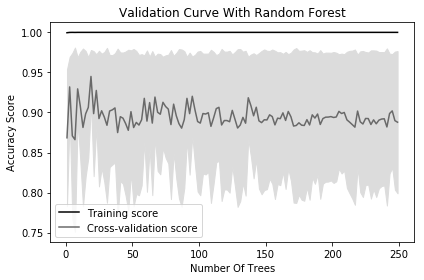

In [52]:
# Plot mean accuracy scores for training and test sets
# # # #
plt.plot(param_range, train_mean, label="Training score", color="black")
plt.plot(param_range, test_mean, label="Cross-validation score", color="dimgrey")
# # # # 
# Plot accurancy bands for training and test sets
plt.fill_between(param_range, test_mean - test_std,
                 test_mean + test_std, color="gainsboro")
# Create plot
plt.title("Validation Curve With Random Forest")
plt.xlabel("Number Of Trees")
plt.ylabel("Accuracy Score")
plt.tight_layout()
plt.legend(loc="best")
plt.savefig('RF.png')

In [0]:
 # Load libraries
import matplotlib.pyplot as plt
import numpy as np
from sklearn.svm import SVC
from sklearn.model_selection import validation_curve


param_range = np.arange(0.1, 10, 0.1)
# Calculate accuracy on training and test set using range of parameter values

train_scores, test_scores = validation_curve( # Classifier
                            SVC(), 
                            # Feature matrix features,
                            X=features_final,
                            # Target vector
                            y=target,
                            # Hyperparameter to examine 
                            param_name="C",
                            # Range of hyperparameter's values 
                            param_range=param_range,
                            # Number of folds
                            cv=3,
                            # Performance metric 
                            scoring="accuracy",
                            n_jobs=-1)


# Calculate mean and standard deviation for training set scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
# Calculate mean and standard deviation for test set scores
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)



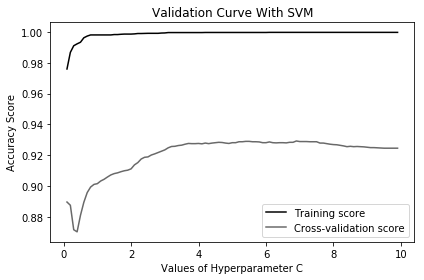

In [56]:
# Plot mean accuracy scores for training and test sets
# # # #
plt.plot(param_range, train_mean, label="Training score", color="black")
plt.plot(param_range, test_mean, label="Cross-validation score", color="dimgrey")
# # # # 

# Create plot
plt.title("Validation Curve With SVM")
plt.xlabel("Values of Hyperparameter C")
plt.ylabel("Accuracy Score")
plt.tight_layout()
plt.legend(loc="best")
plt.savefig('SVM.png')

In [0]:
 # Load libraries
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import validation_curve


param_range = np.arange(0.05, 2, 0.05)
# Calculate accuracy on training and test set using range of parameter values

train_scores, test_scores = validation_curve( # Classifier
                            LogisticRegression(), 
                            # Feature matrix features,
                            X=features_final,
                            # Target vector
                            y=target,
                            # Hyperparameter to examine 
                            param_name="C",
                            # Range of hyperparameter's values 
                            param_range=param_range,
                            # Number of folds
                            cv=3,
                            # Performance metric 
                            scoring="accuracy")


# Calculate mean and standard deviation for training set scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
# Calculate mean and standard deviation for test set scores
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)



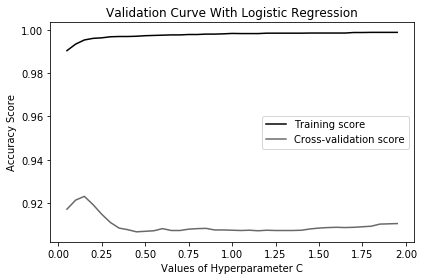

In [58]:
# Plot mean accuracy scores for training and test sets
# # # #
plt.plot(param_range, train_mean, label="Training score", color="black")
plt.plot(param_range, test_mean, label="Cross-validation score", color="dimgrey")
# # # # 

# Create plot
plt.title("Validation Curve With Logistic Regression")
plt.xlabel("Values of Hyperparameter C")
plt.ylabel("Accuracy Score")
plt.tight_layout()
plt.legend(loc="best")
plt.savefig('LR.png')